# Git workflow for MARBL
Given the scientific nature of the MARBL library, it is not practical to expect users to update to the latest version of the library regularly. This workflow is designed to allow bugfixes to be applied to old releases. There are two main branches: _development_ contains the latest development code, and _stable_ is the latest release.

**REQUIREMENT:** _development_ must be even with our directly ahead of _stable_; a new release will be made by _git checkout stable ; git merge development --ff-only_

When a GCM incorporates a specific version of MARBL, we will make a GCM-specific release branch off of _stable_. Example: the _v0.29.0_ on _development_ will correspond to the _v1.0.0-beta01_ tag on _stable_. This is the version of MARBL to be used in CESM 2.0, so we will also make a _cesm2.0_ branch (and a _cesm2.0-n00_ tag) at this point.

In [1]:
import pydot
from copy import deepcopy


# Needed to render pydot graph
# from https://stackoverflow.com/a/36463158
from IPython.display import Image, display
def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

# Modify deepcopy for pydot
def pydot_copy(graph_in):
    graph_out = deepcopy(graph_in)
    graph_out.create_png = graph_in.create_png
    graph_out.add_node = graph_in.add_node
    graph_out.add_edge = graph_in.add_edge
    return graph_out

# Color choices
development = {"label": "dev", "color": "black"}
stable = {"label": "sta", "color": "blue"}
release_branch = {"label": None, "color": "green"}
bugfix_enhancement = {"label": None, "color": "gray"}

## Initial State

To start, we'll think of commit `C0` as "initial release". This exists on three branchs: _development_, _stable_, and _cesm2.0_; it is tagged as _v0.29.0_, _cesm1.0.0-beta01_, and _cesm2.0-n00_.


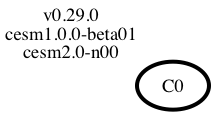

In [14]:
def initial_release():
    # initialize graph
    graph = pydot.Dot(graph_type='graph')

    # Add node for starting point
    C0 = pydot.Node("C0", penwidth=3, xlabel="v0.29.0\ncesm1.0.0-beta01\ncesm2.0-n00")
    graph.add_node(C0)
    return graph

# Draw graph
viewPydot(initial_release())


## Bug found in CESM testing

In the CESM testing, we find an issue. A new _bugfix_ branch is made, the issue is resolved in `C1`, and then the bugfix is merged back to _development_ with `git merge bugfix --no-ff`, resulting in `C2`. Also, _development_ is merged onto _stable_ and _cesm2.0_ with `git merge development --ff-only`. `C2` is tagged as _v0.29.1_, _cesm1.0.0-beta02_, and _cesm2.0-n01_.

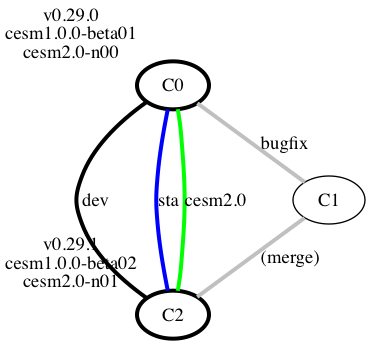

In [15]:
def stage1():
    # Initialize graph
    graph = initial_release()

    # Add node for new release
    C2 = pydot.Node("C2", xlabel="v0.29.1\ncesm1.0.0-beta02\ncesm2.0-n01", penwidth=3)
    graph.add_node(C2)

    # Edges for development, stable, and cesm2.0
    edge = pydot.Edge("C0", "C2", penwidth=3, label=development["label"], color=development["color"]) # edge for development
    graph.add_edge(edge)
    edge = pydot.Edge("C0", "C2", penwidth=3, label=stable["label"], color=stable["color"]) # edge for stable
    graph.add_edge(edge)
    edge = pydot.Edge("C0", "C2", penwidth=3, label="cesm2.0", color=release_branch["color"]) # edge for cesm2.0
    graph.add_edge(edge)

    # Edges for bugfix and merge
    edge = pydot.Edge("C0", "C1", penwidth=3, label="bugfix", color=bugfix_enhancement["color"]) # edge for bugfix
    graph.add_edge(edge)
    edge = pydot.Edge("C1", "C2", penwidth=3, label="(merge)", color=bugfix_enhancement["color"])
    graph.add_edge(edge)
    
    return graph

# Draw graph
viewPydot(stage1())

## Working towards CESM 2.1

Now suppose we are ready to develop something new for CESM 2.1. We create a new branch _enhancement_, and make commits `C3` and `C4` on it, and then merge it back to _development_ with `git merge enhancement --no-ff`, resulting in `C5`. Also, _development_ is merged onto _stable_ with `git merge development --ff-only`, and we create a new branch _cesm2.1_ from this commit. `C5` is tagged as _v0.30.0_, _cesm1.0.0-beta03_, and _cesm2.1-n00_.


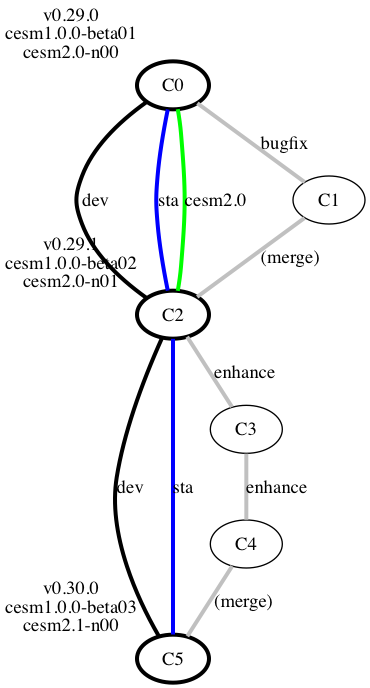

In [16]:
def stage2():
    graph = stage1()

    # Add node for new release
    C5 = pydot.Node("C5", penwidth=3, xlabel="v0.30.0\ncesm1.0.0-beta03\ncesm2.1-n00")
    graph.add_node(C5)

    # Edges for development and stable
    edge = pydot.Edge("C2", "C5", penwidth=3, label=development["label"], color=development["color"]) # edge for development
    graph.add_edge(edge)
    edge = pydot.Edge("C2", "C5", penwidth=3, label=stable["label"], color=stable["color"]) # edge for stable
    graph.add_edge(edge)

    # Edges for enhancement and merge
    edge = pydot.Edge("C2", "C3", penwidth=3, label="enhance", color=bugfix_enhancement["color"]) # edge for bugfix
    graph.add_edge(edge)
    edge = pydot.Edge("C3", "C4", penwidth=3, label="enhance", color=bugfix_enhancement["color"]) # edge for bugfix
    graph.add_edge(edge)
    edge = pydot.Edge("C4", "C5", penwidth=3, label="(merge)", color=bugfix_enhancement["color"])
    graph.add_edge(edge)
    
    return graph

# Draw graph
viewPydot(stage2())

# Oh no, another bug on cesm2.0 release branch!

At this point, we realize there is a bug in `C2` that we want to fix for _cesm2.0_. So we make the _bugfix2_ branch off of `C2`, make commits `C6` and `C7` to fix the bug, and then merge it back to _cesm2.0_ with `git merge bugfix2 --no-ff`, resulting in `C8`. That commit is tagged _cesm2.0-n02_

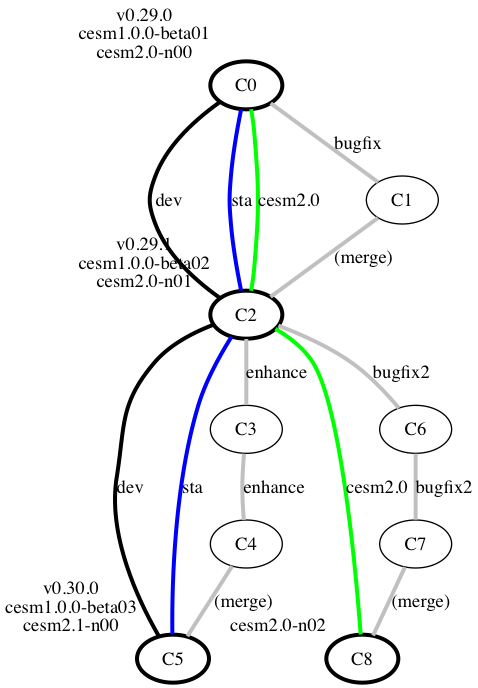

In [17]:
def stage3():
    graph = stage2()

    # Add node for new release
    C8 = pydot.Node("C8", penwidth=3, xlabel="cesm2.0-n02")
    graph.add_node(C8)

    # Edge for cesm2.0
    edge = pydot.Edge("C2", "C8", penwidth=3, label="cesm2.0", color=release_branch["color"])
    graph.add_edge(edge)

    # Edges for bugfix and merge
    edge = pydot.Edge("C2", "C6", penwidth=3, label="bugfix2", color=bugfix_enhancement["color"]) # edge for bugfix
    graph.add_edge(edge)
    edge = pydot.Edge("C6", "C7", penwidth=3, label="bugfix2", color=bugfix_enhancement["color"]) # edge for bugfix
    graph.add_edge(edge)
    edge = pydot.Edge("C7", "C8", penwidth=3, label="(merge)", color=bugfix_enhancement["color"])
    graph.add_edge(edge)
    
    return graph

# Draw graph
viewPydot(stage3())

### Merging bugfix back to development, stable, and cesm2.1

Now that the bug has been fixed in the oldest release, we merge `C7` back to `development` with `git merge enhancement --no-ff`, resulting in `C9`. Also, _development_ is merged onto _stable_ and _cesm2.1_ with `git merge development --ff-only`, and that commit is labeled _v0.30.1_, _v1.0.0-beta04_, and _cesm2.1-n02_.

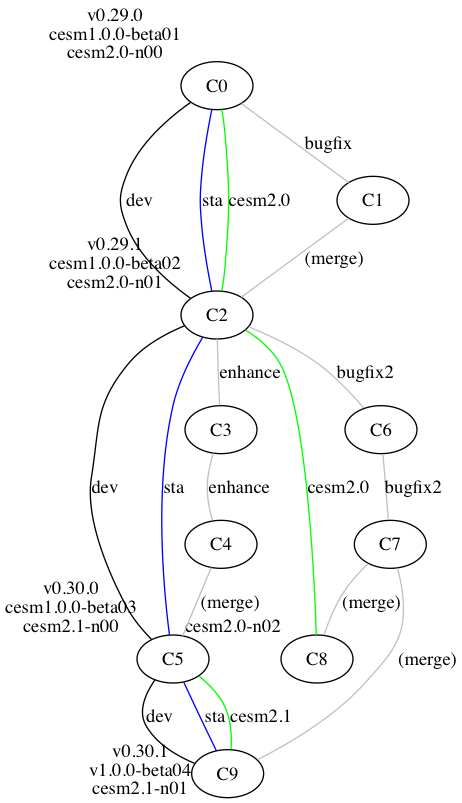

In [6]:
def stage4():
    graph = stage3()

    # Add node for new release
    C9 = pydot.Node("C9", penwidth=3, xlabel="v0.30.1\nv1.0.0-beta04\ncesm2.1-n01")
    graph.add_node(C9)

    # Edges for development, stable, and cesm2.1
    edge = pydot.Edge("C5", "C9", penwidth=3, label=development["label"], color=development["color"]) # edge for development
    graph.add_edge(edge)
    edge = pydot.Edge("C5", "C9", penwidth=3, label=stable["label"], color=stable["color"]) # edge for stable
    graph.add_edge(edge)
    edge = pydot.Edge("C5", "C9", penwidth=3, label="cesm2.1", color=release_branch["color"]) # edge for cesm2.0
    graph.add_edge(edge)

    # Edges for merge
    edge = pydot.Edge("C7", "C9", penwidth=3, label="(merge)", color=bugfix_enhancement["color"])
    graph.add_edge(edge)
    
    return graph

# Draw graph
viewPydot(stage4())

## Enhancement that leads to v1.0.0

Now we are ready to develop something new for MARBL v1.0.0, we just want to add two new features.

### First feature

We create a new branch _feature_ off of `development`, and make commits `C10`, `C11`, and `C12` on it, and then merge it back to _development_ with `git merge enhancement --no-ff`, resulting in `C13`. This is tagged `v1.0-beta0.1`.

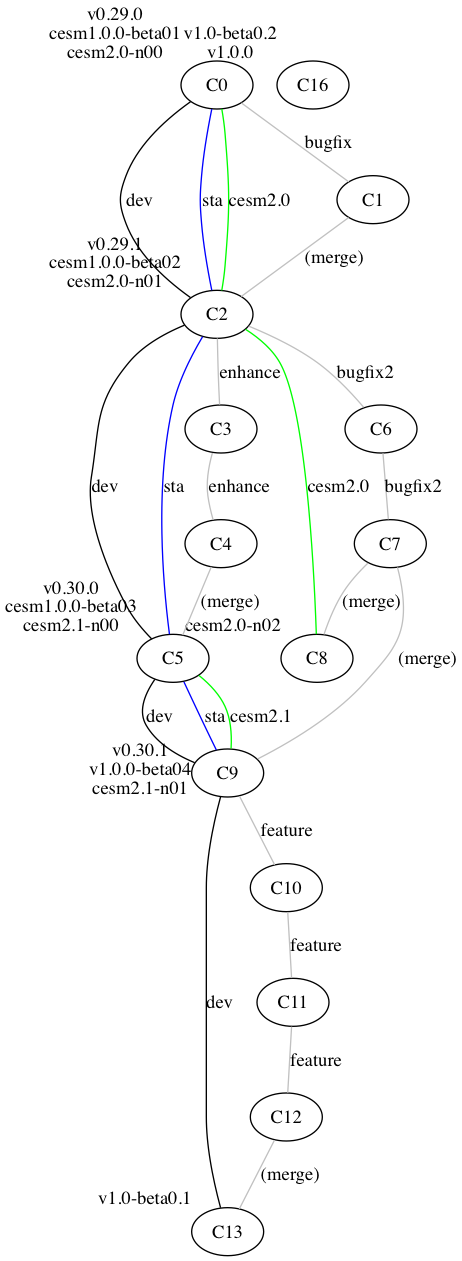

In [7]:
def stage5():
    graph = stage4()

    # Add nodes for new releases
    C13 = pydot.Node("C13", xlabel="v1.0-beta0.1")
    graph.add_node(C13)
    C16 = pydot.Node("C16", xlabel="v1.0-beta0.2\nv1.0.0")
    graph.add_node(C16)

    # Edges for feature
    edge = pydot.Edge("C9", "C10", label="feature", color=bugfix_enhancement["color"]) # edge for bugfix
    graph.add_edge(edge)
    edge = pydot.Edge("C10", "C11", label="feature", color=bugfix_enhancement["color"]) # edge for bugfix
    graph.add_edge(edge)
    edge = pydot.Edge("C11", "C12", label="feature", color=bugfix_enhancement["color"]) # edge for bugfix
    graph.add_edge(edge)
    edge = pydot.Edge("C12", "C13", label="(merge)", color=bugfix_enhancement["color"])
    graph.add_edge(edge)

    # Edge for development
    edge = pydot.Edge("C9", "C13", label=development["label"], color=development["color"]) # edge for development
    graph.add_edge(edge)

    return graph

# Draw graph
viewPydot(stage5())

### Second feature

Next we create a new branch _feature2_ off of `development`, and make commits `C14` and `C15` on it, and then merge it back to _development_ with `git merge enhancement --no-ff`, resulting in `C16`. This is tagged `v1.0-beta0.2`.

Assuming we are happy with pre-release testing, _development_ is merged onto _stable_ with `git merge development --ff-only` and `C16` also gets tagged `v1.0.0`.

**NOTE:** `C13` is in the direct (`--first-parent`) history of _stable_ but there was never a time that it was the `HEAD` of stable.

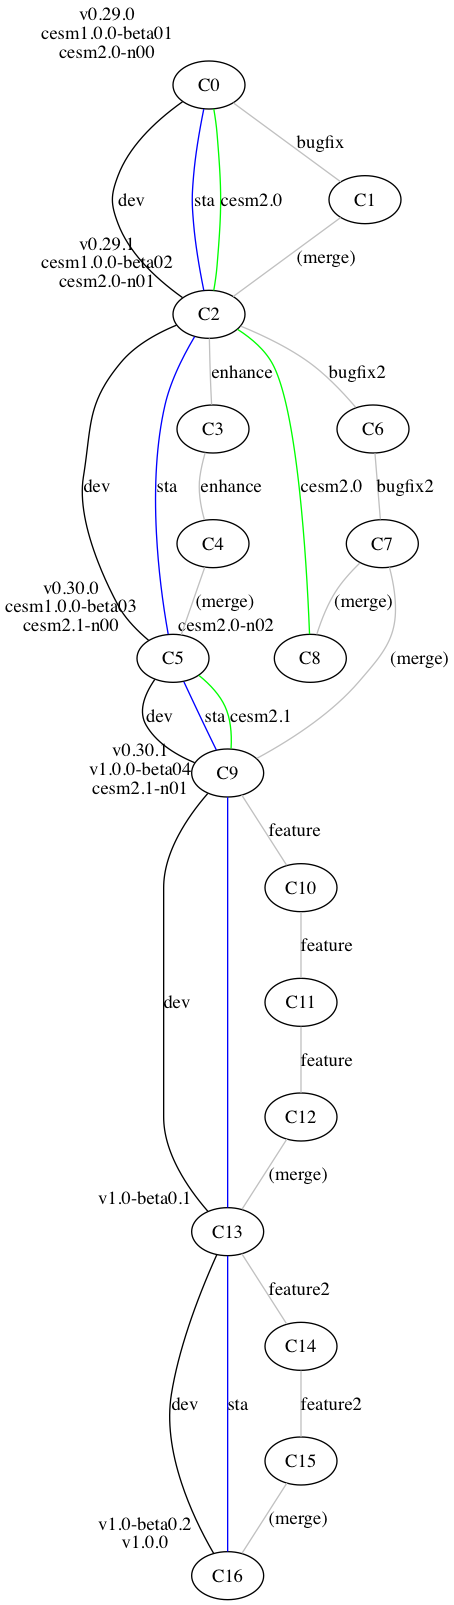

In [8]:
def stage6():
    graph = stage5()

    # Edges for development and stable
    edge = pydot.Edge("C13", "C16", label=development["label"], color=development["color"]) # edge for development
    graph.add_edge(edge)
    edge = pydot.Edge("C9", "C13", color=stable["color"]) # edge for stable
    graph.add_edge(edge)
    edge = pydot.Edge("C13", "C16", label=stable["label"], color=stable["color"]) # edge for stable
    graph.add_edge(edge)

    # Edges for feature2
    edge = pydot.Edge("C13", "C14", label="feature2", color=bugfix_enhancement["color"]) # edge for bugfix
    graph.add_edge(edge)
    edge = pydot.Edge("C14", "C15", label="feature2", color=bugfix_enhancement["color"]) # edge for bugfix
    graph.add_edge(edge)
    edge = pydot.Edge("C15", "C16", label="(merge)", color=bugfix_enhancement["color"])
    graph.add_edge(edge)
    
    return graph

# Draw graph
viewPydot(stage6())